## Описание проекта "Games"
Вы работаете в интернет-магазине «, который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр выпущенных для США и Канады.

</font><font color='Blue'><b>
    Описание данных:
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Для ответа на поставленные вопросы я планирую определить релевантный для прогнозирования период и в его рамках найти перспективные платформы и жанры. Кроме того, я определю, как сильно влияют рейтинги на прибыль.
    </b></font><br>


## Шаг 1. Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from scipy import stats as st

import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    data = pd.read_csv('games.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')
pd.options.display.float_format = '{:.2f}'.format

#Посмотрим информацию о датасете:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [3]:
#Вывелем на экран часть датасета:
data.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.00,Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,nan,NaN,NaN
2,Mario Kart Wii,Wii,2008.00,Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,2009.00,Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,nan,NaN,NaN


In [4]:
data.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.00,16715.00,16715.00,16715.00,16715.00,8137.00
mean,2006.48,0.26,0.15,0.08,0.05,68.97
std,5.88,0.81,0.50,0.31,0.19,13.94
min,1980.00,0.00,0.00,0.00,0.00,13.00
25%,2003.00,0.00,0.00,0.00,0.00,60.00
50%,2007.00,0.08,0.02,0.00,0.01,71.00
75%,2010.00,0.24,0.11,0.04,0.03,79.00
max,2016.00,41.36,28.96,10.22,10.57,98.00


## Шаг 2. Подготовим данные

### Приведём названия столбцов к нижнему регистру

In [5]:
data.columns = data.columns.str.lower()
#data.head(5)

### Обработаем пропуски где это необходимо:

In [6]:
#Проверим на явные дубликаты:
data.duplicated().sum()

0

In [7]:
#Выясним, где имеются пропуски
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [8]:
#интересно посмотреть на строки без названий игр.
#print(data[data['name'].isna()])

</font><font color='Blue'><b>Удалим пропуски в столбцах name genre и year_of_release. Наш анализ будет строиться по годам, поэтому нет смысла оставлять строки без года выпуска в датасете.</b></font><br> Пропуски в этих столбцах могли появиться по разным причинам: техническим или связанными с человеческим фактором. Наиболее вероятным вариантом мне представляется ситуация с утерей этих данных при копировании. Возможно, данные по ним были в старом формате, который не поддерживается.

In [9]:
data = data.dropna(subset=['genre', 'name','year_of_release'])
#data.isna().sum()

TBD - аббревиатура от английского To Be Determined (будет определено) или To Be Decided (будет решено). Используется, если какая-то информация еще не определена или решение по вопросу не принято. То есть, это тот же NaN на специальном игровом диалекте. Скорее всего, оценки в этом случае или не ставились, или их было недостаточно для рейтинга.
Посмотрим, много ли таких tbd:

In [10]:
print(data[data['user_score']=='tbd']['user_score'].count())

2376


Больше 2 тысяч строк. Их надо пометить как и другие с отсутвующими данными.
Чтобы данные были численными, 
</font><font color='Blue'><b>заполню TBD значением "-2", а пропуски в user_score и critic_score на "-1". Пропуски в рейтинке заполню заглушкой 'undefined':</b></font><br>

In [11]:
data['user_score'] = data['user_score'].fillna(-1)
data['user_score'] = data['user_score'].replace('tbd',-2)
data['critic_score'] = data['critic_score'].fillna(-1)
data['rating'] = data['rating'].fillna('undefined')

In [12]:
#промежуточная проверка
#data['year_of_release'].unique()

### Преобразуем данные в нужные типы:

In [13]:
#год выхода игры должен быть целым числом
data['year_of_release'] = data['year_of_release'].astype('int')
#оценки критиков также приведу к целочисленному типу:
data['critic_score'] = data['critic_score'].astype('int')
#оценки зрителей приведу к числовому типу, похоже, они в 10-бальной шкале:
data['user_score'] = data['user_score'].astype('float')
#продажи указаны в миллионах, поэтому данные после запятой ценны, эти столбцы я оставлю без изменений.

In [14]:
#промежуточная проверка
#data.isna().sum()

### Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.

In [15]:
data['total_sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

In [16]:
data.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.00,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.00,undefined,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.30,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.00,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.00,undefined,31.38


In [17]:
# Посмотрим, что у нас осталось
temp = data.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int32
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       16444 non-null int32
user_score         16444 non-null float64
rating             16444 non-null object
total_sales        16444 non-null float64
dtypes: float64(6), int32(2), object(4)
memory usage: 1.5+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']
name : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
platform ['2600' '3DO' '3DS' 'DC' 'DS' 'GB' 'GBA' 'GC' 'GEN' 'GG' 'N64' 'NES' 'NG'


## Шаг 3. Проведём исследовательский анализ данных

### Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

,games,money
year_of_release,,
1980,9,11.38
1981,46,35.68
1982,36,28.88
1983,17,16.80
1984,14,50.35
1985,14,53.95
1986,21,37.08
1987,16,21.70
1988,15,47.21


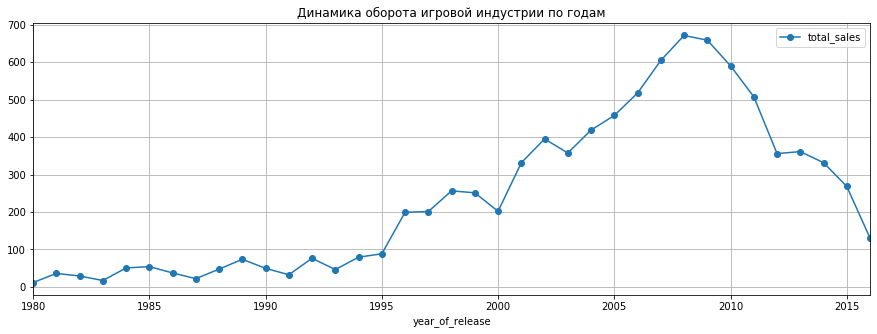

In [18]:
data_year = data.pivot_table(index='year_of_release', values='total_sales', aggfunc=['count','sum'])
data_year.columns = ['games','money']
display(data_year)
#построим график по суммарным продажам:
data.pivot_table(index='year_of_release', 
                 values='total_sales', 
                 aggfunc='sum').plot(grid=True, figsize=(15,5), style='o-', y='total_sales', title = 'Динамика оборота игровой индустрии по годам')

Из получившейся таблицы видно, что пик выпуска игр пришелся на 2006-2011 годы, в этот же период мы видим и максимальный оборот денег в этой сфере.

С 1980 по 1993 годы продажи незначительны, а в 1994 произошел резкий скачок количества выпускаемых игр и с тех пор количество игр равномерно и интенсивно росло в каждом последующем году до пика в 2008-2009 годах. 

Таким образом, данные до 1994 года можно отбросить.

В 2012 происходит резкое падение количества новых игр. Я бы рассматривала именно последний период наиболее подробно, так как он ближе к нам по времени и лучше отражает тенденции 2017 года.

### Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

          games   money
platform               
PS2        2127 1233.56
X360       1232  961.24
PS3        1306  931.34
Wii        1286  891.18
DS         2121  802.78
PS         1190  727.58
PS4         392  314.14
GBA         811  312.88
PSP        1193  289.53
3DS         512  257.81
PC          957  255.76
GB           97  254.43
XB          803  251.57
NES          98  251.05
N64         316  218.01
SNES        239  200.04
GC          542  196.73
XOne        247  159.32
2600        116   86.48
WiiU        147   82.19
PSV         429   53.81
SAT         173   33.59
GEN          27   28.35
DC           52   15.95
SCD           6    1.86
NG           12    1.44
WS            6    1.42
TG16          2    0.16
3DO           3    0.10
GG            1    0.04
PCFX          1    0.03


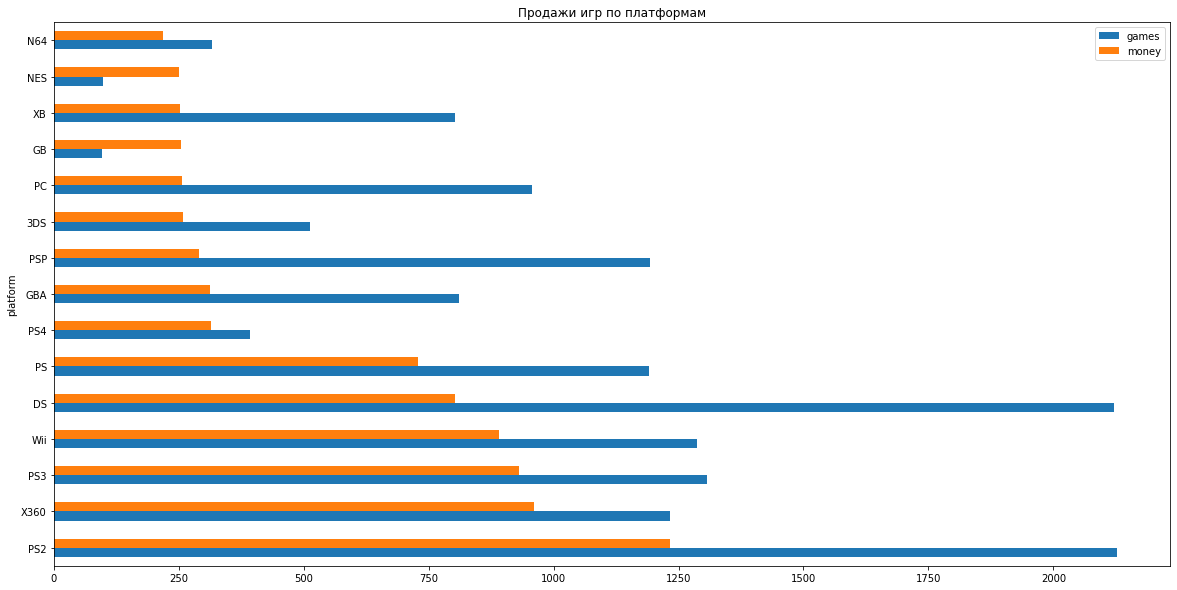

In [19]:
data_platform = data.pivot_table(index='platform', values='total_sales', aggfunc=['count','sum'])
data_platform.columns = ['games','money']
data_platform =data_platform.sort_values('money',ascending = False)
print(data_platform)
data_platform.head(15).plot(kind='barh',figsize=(20, 10),
          title='Продажи игр по платформам')

Безусловными лидерами по продажам являются первые 6 платформ. Рассмотрим их подробнее и построим графики для них:

In [20]:
#отфильтруем данные по самым популярным платформам, параллельно отбросим данные до 1994 года:
data_top_platform = data.query('platform in ("PS2","X360","PS3","Wii","DS","PS") and year_of_release >1994').reset_index(drop=True)
data_top_platform.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.00,E,82.54
1,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.30,E,35.52
2,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.00,E,32.77
3,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.50,E,29.80
4,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58,6.60,E,28.91


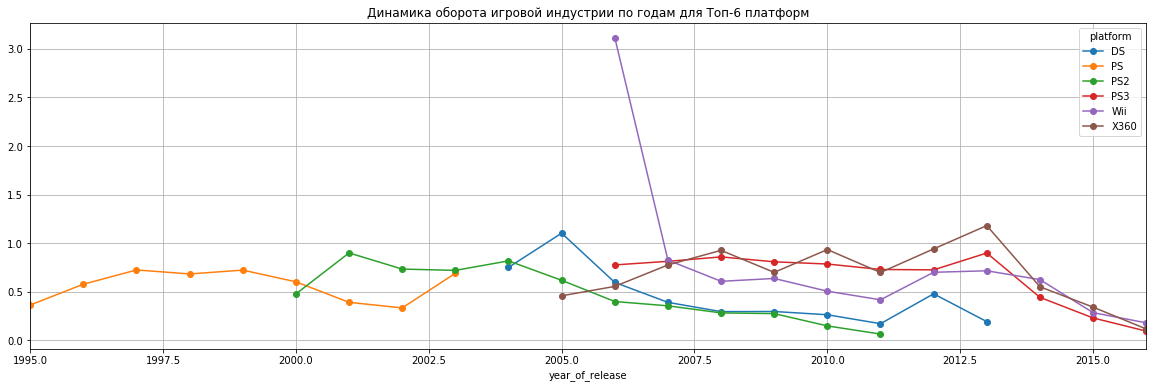

In [21]:
data_pivot = data_top_platform.pivot_table(index='year_of_release',columns = 'platform', values='total_sales')
data_pivot.plot(grid=True, figsize=(20,6), style='o-', title = 'Динамика оборота игровой индустрии по годам для Топ-6 платформ')

In [22]:
data_pivot.describe()

platform,DS,PS,PS2,PS3,Wii,X360
count,10.00,9.00,12.00,11.00,11.00,12.00
mean,0.45,0.57,0.48,0.65,0.78,0.68
std,0.29,0.16,0.27,0.27,0.80,0.30
min,0.17,0.33,0.06,0.09,0.18,0.12
25%,0.27,0.39,0.28,0.58,0.46,0.53
50%,0.34,0.60,0.44,0.78,0.62,0.70
75%,0.57,0.69,0.72,0.81,0.71,0.93
max,1.10,0.72,0.90,0.90,3.12,1.18


Самые прибыльные платформы существуют чуть больше 10 лет, в среднем 11. 
PS3	Wii	X360 ещё не закончили своё существование в 2016 году и имеют шансы на дальнейшую работу.
Интересно рассмотреть PS2 и PS3: вторая платформа явно была запущена взамен первой, переход занимает около 5 лет, то есть почти половину срока службы платформы.

### Выделим соответствующий актуальный период, данные за который помогут построить прогноз на 2017 год.

                 games  money
year_of_release              
1995               219  88.12
1996               263 199.15
1997               289 201.07
1998               379 256.31
1999               338 251.11
2000               350 201.66
2001               482 331.46
2002               829 394.97
2003               775 357.54
2004               762 418.68
2005               939 457.82
2006              1006 517.71
2007              1197 604.75
2008              1427 671.50
2009              1426 658.82
2010              1255 590.13
2011              1136 507.58
2012               653 355.84
2013               544 361.24
2014               581 331.53
2015               606 267.98
2016               502 129.94


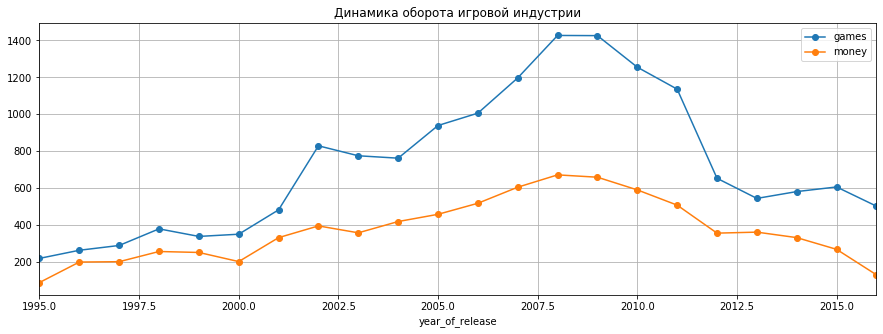

In [23]:
data_filtered_year = data.query('year_of_release >1994').reset_index()
data_since_1994 = data_filtered_year.pivot_table(index='year_of_release', values='total_sales', aggfunc=['count','sum'])
data_since_1994.columns = ['games','money']
print(data_since_1994)
data_since_1994.plot(style='o-', title = 'Динамика оборота игровой индустрии', figsize = (15,5), grid=True)

Для исследования я возьму данные с 2012 года. Хочу, чтобы в исследование вошли наиболее современные платформы. Рынок игр очень прогрессивный и изменчивый, ситуация 2006-2011 годов в корне отличается от того, что сейчас.
Отфильтруем данные по актуальному периоду:

In [24]:
data_actual = data.query('year_of_release >= 2012').reset_index()

### Определим, какие платформы лидируют по продажам, растут или падают. 
Выберем несколько потенциально прибыльных платформ.

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,51.36,11.01,23.22,107.36,nan,7.69,16.19,21.71,17.56,99.74,nan
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,nan,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,nan,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,nan,5.25,3.60,69.25,nan,4.25,0.18,4.60,1.52,26.15


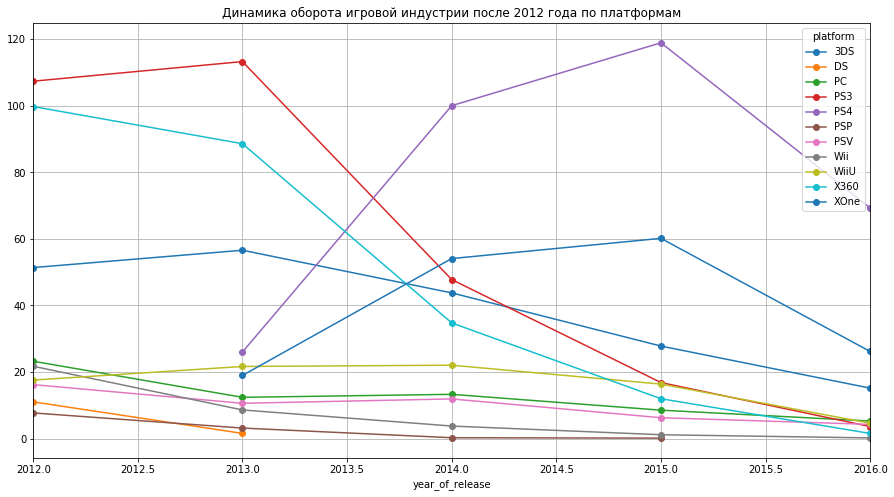

In [25]:
data_actual.pivot_table(index='year_of_release', columns = 'platform', values='total_sales', aggfunc='sum').plot(grid=True, style='o-', figsize = (15,8), title = 'Динамика оборота игровой индустрии после 2012 года по платформам')
data_actual.pivot_table(index='year_of_release', columns = 'platform', values='total_sales', aggfunc='sum')

Данные за 2016 год неполные, так что на спады в конце графиков можно не обращать внимания. PS4 и XOne наиболее перспективные платформы. Они начали своё развитие в 2013 году и для 2016-2017 годов являлись новыми. 3DS и WiiU тоже можно не списывать со счетов, их падение менее резкое, чем у конкурентов. PC максимально стабильный вариант, его надо всегда держать в уме.

### Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

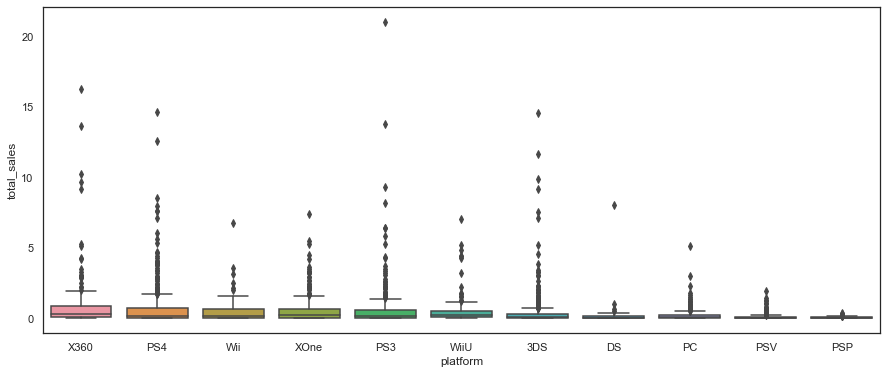

In [26]:
grouped = (
    data_actual.groupby('platform')['total_sales']
    .describe()
    .sort_values('mean', ascending = False)
)

for_box = data_actual.copy()
for_box['platform'] = 'total_sales'
for_box = pd.concat([for_box, data_actual], axis = 0)

sb.set(rc={'figure.figsize':(15,6)})
sb.set_style(style='white')
sb.boxplot(x=for_box.platform,y=for_box.total_sales,order=grouped.index)

У платформ имеются суперуспешные игры, которые смещают графики и ящик с усами получается плоским и неинформативным. Ограничим график по оси "Y":

(0, 2)

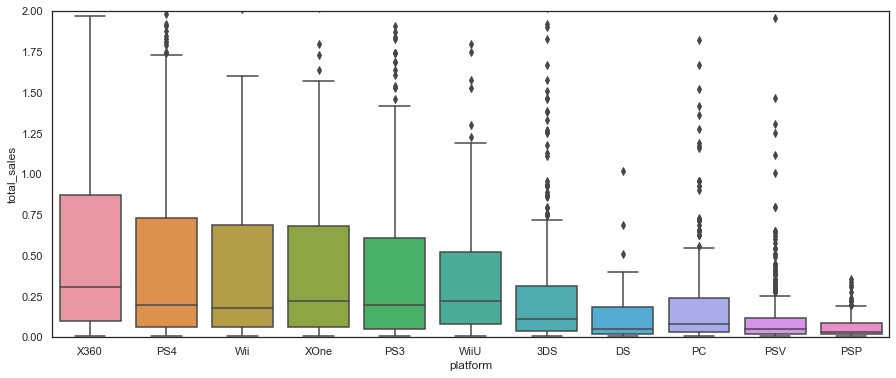

In [27]:
sb.set(rc={'figure.figsize':(15,6)})
sb.set_style(style='white')
sb.boxplot(x=for_box.platform,y=for_box.total_sales,order=grouped.index)
plt.ylim(0, 2)

По ящикам с усами можно сказать, что наиболее денежными платформами в выбранный период были X360, PS4, Wii, XOne, WiiU. 
</font><font color='Blue'><b>На расположенных выше диаграммах размаха мы можем увидеть как распределены значения распространённости игр по платформам. Все графики имеют смещение вправо, что обозначает больший разброс значений количества проданных копий игр в этом направлении. Почти во всех случаях присутствуют далёкие выпады в большую сторону: это игры-бестселлеры, визитные карточки платформ. В данном периоде времени самая распространённая платформа Х360, она имеет наибольшее медианное количество проданных копий, диапазон значений максимально из всех платформ удалён от нуля, это обозначает наибольшее количество копий игр, распространённых среди пользователей. У затухающей PSP даже самые далёкие выпады не превышают границу межквартильного размаха шести самых популярных игр.</b></font><br>

### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построем диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. 

In [28]:
print(len(data_actual.query('critic_score >=0')))
print(len(data_actual.query('user_score >=0')))
print(len(data_actual.query('critic_score >=0 and user_score >=0')))

1312
1531
1297


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


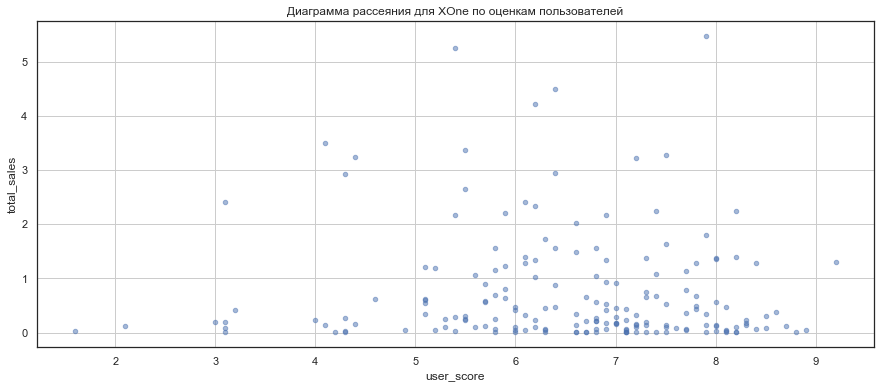

In [29]:
data_actual_user = data_actual.query('user_score >= 0 and platform == "XOne"')
data_actual_user.plot(x='user_score', y='total_sales',kind='scatter',grid=True,alpha=0.5,title = "Диаграмма рассеяния для XOne по оценкам пользователей")


<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkGreen'>👌 Когда у нас выскакивают предупреждения, это означает, что в будущей новой версии библиотеки применяемый метод обработки будет не применим. Если мы планируем данный код использовать в будущем, то надо разобраться и изменить код. Если нам он в будущем не понадобится, то можно принудительно запретить вывод предупреждений вставив в ячейку с библиотеками вот такой код: <br>`pd.set_option('chained_assignment', None)` или такой: <br></font>
`import warnings`<br>
`warnings.filterwarnings("ignore")`

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


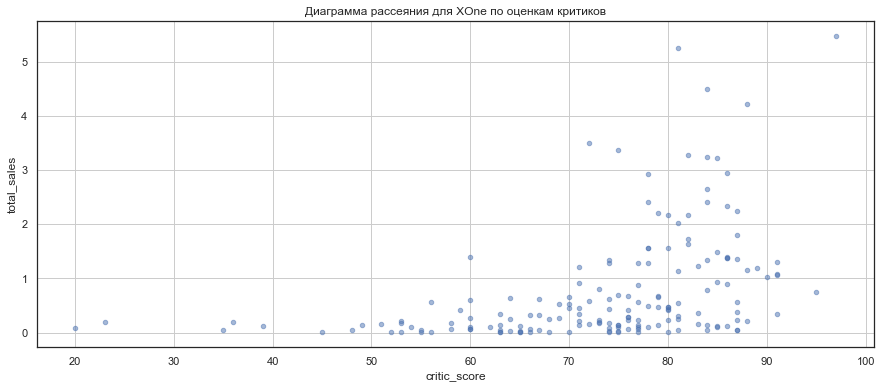

In [30]:
data_actual_critic = data_actual.query('critic_score >= 0 and platform == "XOne"')
data_actual_critic.plot(x='critic_score', y='total_sales',kind='scatter',grid=True,alpha=0.5,title = "Диаграмма рассеяния для XOne по оценкам критиков")

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='Red'>🛠 Конечно, диаграмма попарных отношений очень удобна, но в нашем случае она не информативна, так как из-за малого масштаба данных у нас отзывы просто сливаются. Лучше использовать точечные диаграммы: `.plot(kind='scatter',......)`.</font>

</font><font color='Blue'><b>Готово</b></font><br>

In [31]:
print("Матрица корреляций")
data_actual_user[['total_sales', 'user_score']].corr()

Матрица корреляций


,total_sales,user_score
total_sales,1.00,-0.07
user_score,-0.07,1.00


In [32]:
data_actual_critic[['total_sales', 'critic_score']].corr()

,total_sales,critic_score
total_sales,1.00,0.42
critic_score,0.42,1.00


На платформе XOne прослеживается небольшая зависимость между оценками критиков и продажами. Зависимости от оценок пользователей не наблюдается. 

### Соотнесём выводы с продажами игр на других платформах.

Посмотрим на схожие коэффициенты корреляции для других платформ.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.



                                                          3DS


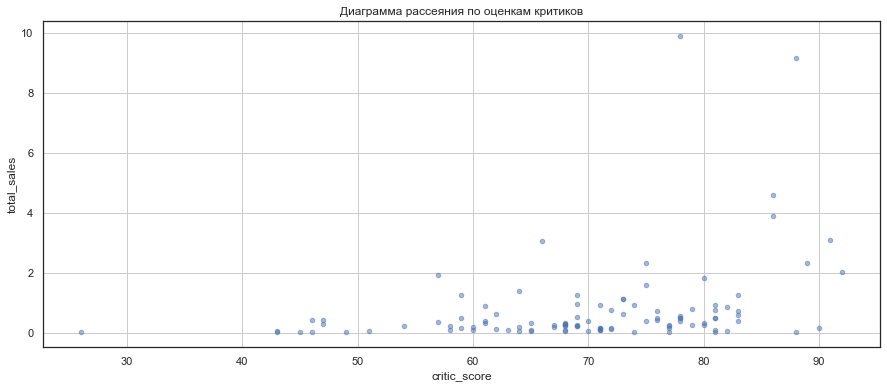

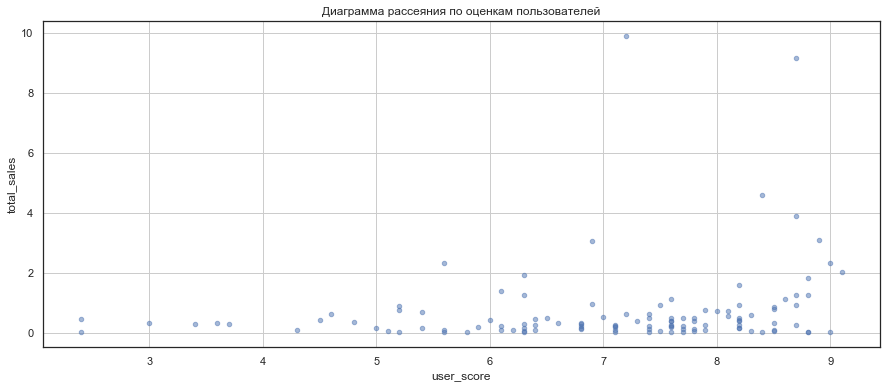

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


corr_user 0.19758263411038596
corr_critic 0.32080286953607856

--------------------------------------------------

                                                          PC


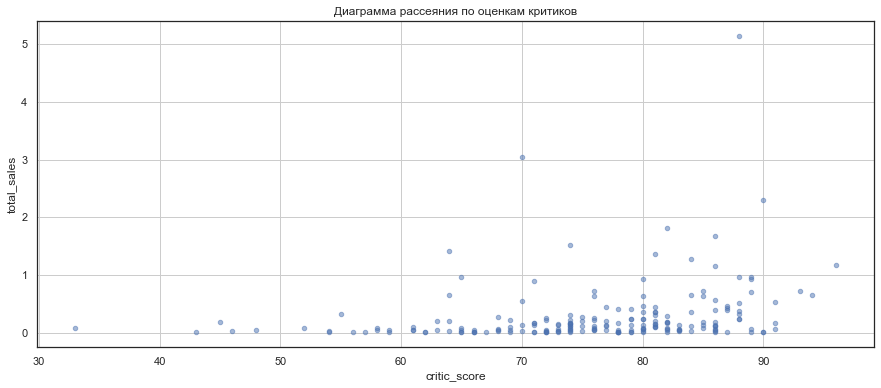

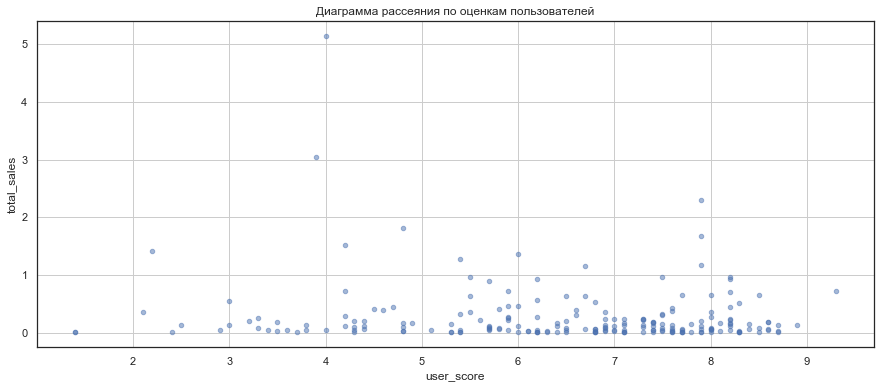

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


corr_user -0.12186747630735568
corr_critic 0.23724324311567932

--------------------------------------------------

                                                          PS4


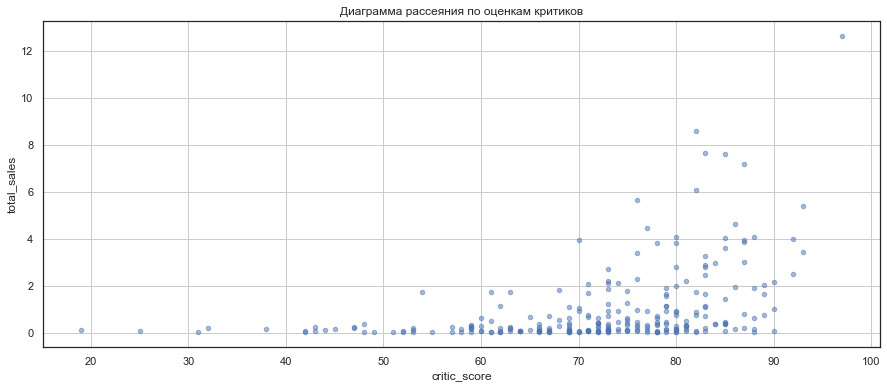

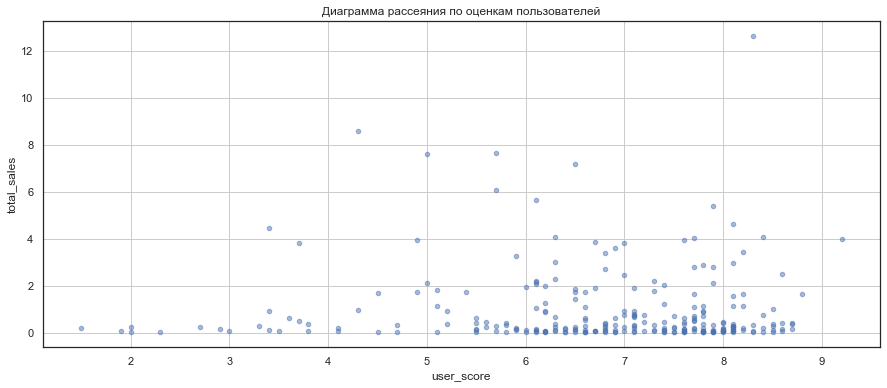

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


corr_user -0.03195711020455645
corr_critic 0.4065679020617815

--------------------------------------------------

                                                          WiiU


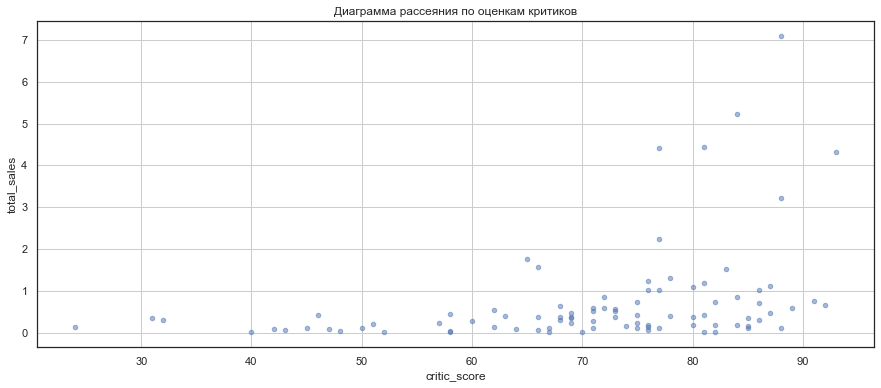

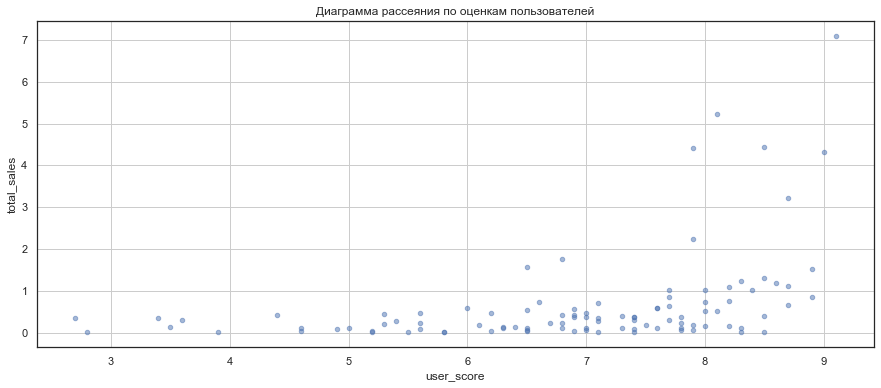

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


corr_user 0.40021902021486155
corr_critic 0.3483797601201747

--------------------------------------------------

                                                          X360


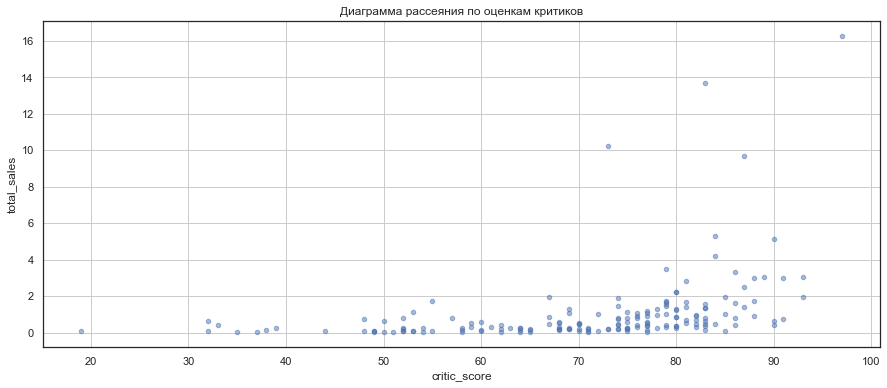

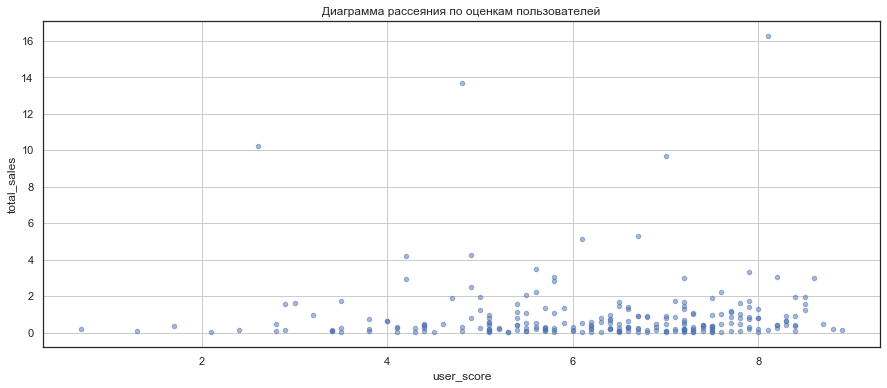

corr_user 0.006163978646213352
corr_critic 0.3605734888507337

--------------------------------------------------


In [33]:
#Список платформ для анализа
list = ['3DS','PC','PS4','WiiU','X360']
def other_platform_matrix(name_of_platform):
    platform =data_actual[data_actual['platform']==name_of_platform]
    print()
    print("                                                         ",name_of_platform)
    data_critic = platform.query('critic_score >= 0')
    data_critic.plot(x='critic_score', y='total_sales',kind='scatter',grid=True,alpha=0.5,title = "Диаграмма рассеяния по оценкам критиков")
    data_user = platform.query('user_score >= 0')
    data_user.plot(x='user_score', y='total_sales',kind='scatter',grid=True,alpha=0.5,title = "Диаграмма рассеяния по оценкам пользователей")
    plt.show()
    
    print('corr_user',data_user['user_score'].corr(data_user['total_sales']))
    print('corr_critic',data_critic['critic_score'].corr(data_critic['total_sales']))
    print()
    print('-'*50)
    
for platform in list:
    other_platform_matrix(platform)

</font><font color='Blue'><b>Для большинства платформ имеется та же самая тенденция: распространённость игры не зависит от отзывов пользователей, но имеет небольшую корреляцию с оценками критиков. WiiU является исключением: игры на этой платформе чуть более чувствительны к оценкам пользователей, чем критиков . Игры же на РС наиболее независимы от оценок.</b></font><br>

### Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

              games  money  average
genre                              
Action         1031 441.12     0.43
Shooter         235 304.73     1.30
Role-Playing    370 192.80     0.52
Sports          268 181.07     0.68
Misc            192  85.04     0.44
Platform         85  61.00     0.72
Racing          115  53.50     0.47
Fighting        109  44.49     0.41
Simulation       80  35.12     0.44
Adventure       302  29.43     0.10
Strategy         71  13.34     0.19
Puzzle           28   4.89     0.17


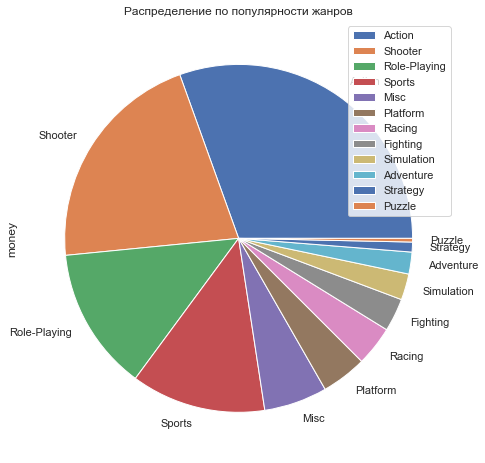

In [34]:
data_genre = data_actual.pivot_table(index='genre', values='total_sales', aggfunc=['count','sum'])
data_genre.columns = ['games','money']
data_genre =data_genre.sort_values('money',ascending = False)
data_genre['average'] = data_genre['money']/data_genre['games']
print(data_genre)
data_genre.plot(y='money', kind='pie',figsize=(8,8), title = 'Распределение по популярности жанров')
#data_actual.pivot_table(index='genre', columns = 'platform', values='total_sales', aggfunc='sum').plot(kind='hist',grid=True, figsize = (20,8))

Лидерами по количеству игр и по денежному обороту стал жанр "Action". За выбранный период их выпустилось примерно столько же, сколько игр четырёх других популярных жанров. Shooter на 2 месте по денежному обороту, но этот жанр лидирует по заработку на одну выпущенную игру. Role-Playing, Sports также приносят хорошую прибыль.
Жанры Adventure и Puzzle не очень прибыльны, каждая выпущенная игра зарабатывает в 5 раз меньше, чем средняя игра в жанрах-лидерах. 

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Хорошо, что мы не попали в ловушку, что максимальные продажи являются самыми прибыльными. В данных продажи по жанру для разных платформ и если одна платформа со своей одной игрой в данном жанре выстрелила, а остальные провалились, то мы все равно будем видеть максимум общих продаж, даже если остальные платформы по этому жанру были не удачны. Но для прибыльности нам нужны стабильные жанры, который приносит доход не зависимо от платформы, значит на этот жанр есть устойчивый спрос.  Было бы не плохо сравнение продаж проиллюстрировать диаграммой размаха. Сделаем? </font>

## Шаг 4. Составьте портрет пользователя каждого региона

### Самые популярные платформы (топ-5). Опишем различия в долях продаж.

In [35]:
def top_by_regions(groupby, reg_sales, ax):
    pivot = data_actual.groupby(groupby).agg({reg_sales: 'sum'}).sort_values(by=reg_sales, ascending=False)[:5]
    plot = pivot.plot(kind='bar', ec='black', ax=axes[ax], 
                   fontsize=18, rot=20)
    plot.legend(prop={'size':17})
    plot.set_xlabel('')
    plot.title.set_size(20)

Топ 5 платформ по регионам


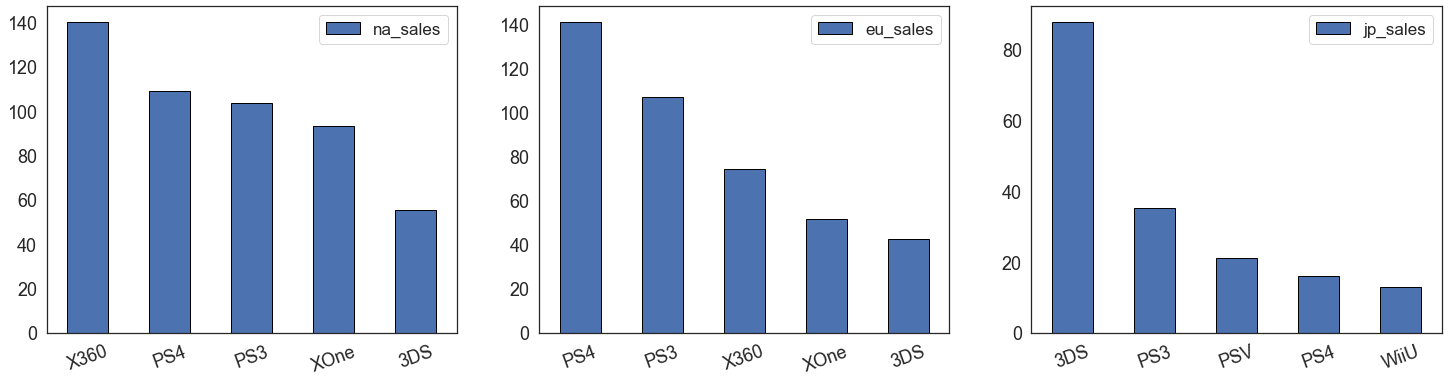

In [36]:
print ('Топ 5 платформ по регионам')
fig, axes = plt.subplots(1, 3, figsize=(25,6))

top_by_regions('platform', 'na_sales', 0)
top_by_regions('platform', 'eu_sales', 1)
top_by_regions('platform', 'jp_sales', 2)

В Северной Америке наиболее популярны приставки X360 и PS4, PS3. Далее идут XOne и 3DS.

В Европе популярны PS4. За ней PS3, X360, XOne и 3DS.

В Японии с большим отрывом лидирует 3DS, далее идут PS3, PSV,PS4 и WiiU.

### Самые популярные жанры (топ-5). Поясним разницу.

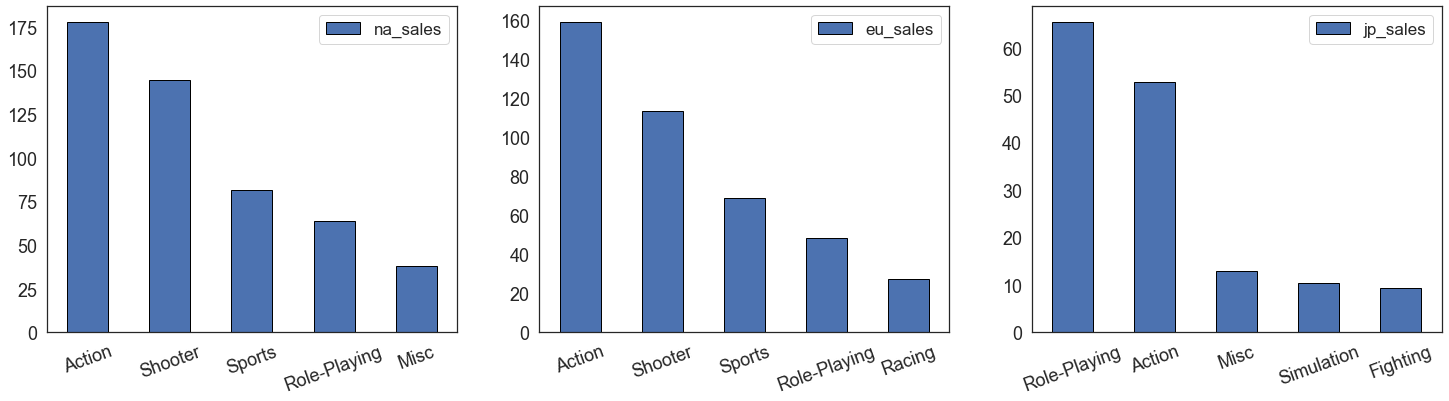

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

top_by_regions('genre', 'na_sales', 0)
top_by_regions('genre', 'eu_sales', 1)
top_by_regions('genre', 'jp_sales', 2)

Игроки в Северной Америке и Европе схожи по предпочтениям: на первом месте Action, далее идут Shooter, Sports, Role-Playing. На 5 месте в Северной Америке Misc, а в Европе Racing.
Ситуация в Японии отличается: с большим отрывом лидируют Role-Playing и Action, кроме того, в пятёрку вошли Misc, Simulation, Fighting.

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [38]:
ESRB_dict = {'E': 'Для всех','EC': '> 6 лет', 'E10+': '> 10 лет', 'M': '> 17 лет', 'T': '> 13 лет', 'AO': 'Для взрослых', 'RP': 'Рейтинг обсуждается', 'unknown': 'Не определен'}
data_actual['ESRB_list'] = data_actual[data_actual['rating'].notnull()]['rating'].map(ESRB_dict)

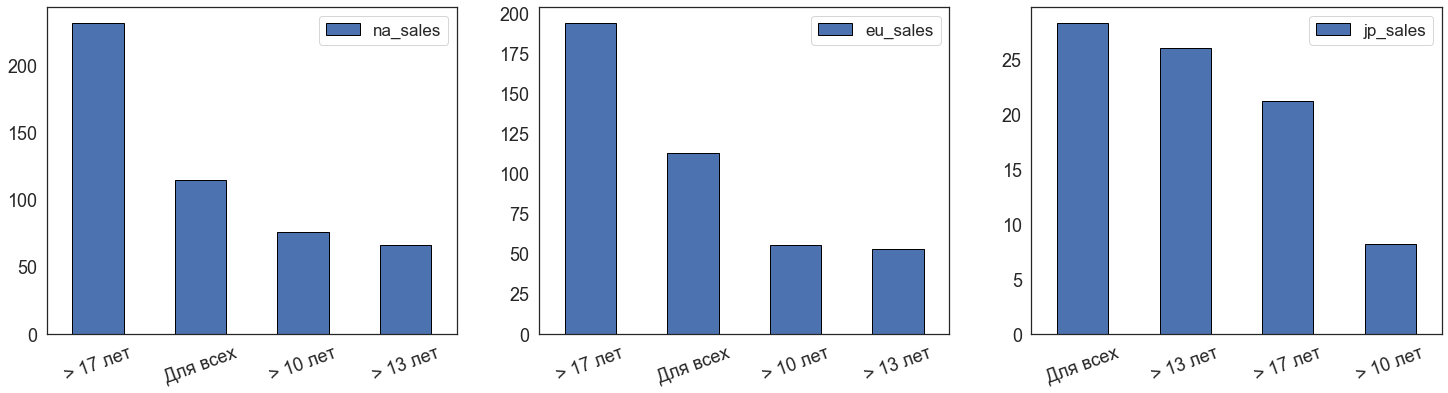

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

top_by_regions('ESRB_list', 'na_sales', 0)
top_by_regions('ESRB_list', 'eu_sales', 1)
top_by_regions('ESRB_list', 'jp_sales', 2)

Что касается рейтинга ESRB, ситуация похожа на предыдущую. Северная Америка и Европа схожи по предпочтениям. Японцы, скорее всего, не используют эту систему для маркировки игр: с большим отрывом лидирует группа без присвоенного ESRB рейтинга.

## Шаг 5. Проверим гипотезы

### 1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.


* Н0 - нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые

* Н1 -альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC различные
    
Для решения этой задачи подойдёт специальный метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам

Для сравнения необходимо сформировать срезы:

In [40]:
pc_user_score = data_actual.query('platform == "PC" and user_score >= 0')['user_score']
xone_user_score = data_actual.query('platform == "XOne" and user_score >= 0')['user_score']

In [41]:
alpha = .05 

results = st.ttest_ind(
    pc_user_score, 
    xone_user_score)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.5535080500643661
Не получилось отвергнуть нулевую гипотезу


In [42]:
print('Средний пользовательский рейтинг платформы PC:', np.mean(pc_user_score))
print('Средний пользовательский рейтинг платформы Xbox One:', np.mean(xone_user_score))

Средний пользовательский рейтинг платформы PC: 6.428640776699027
Средний пользовательский рейтинг платформы Xbox One: 6.52142857142857


</font><font color='Blue'><b>Делаем вывод, что мы не можем отрицать того, что пользовательские рейтинги платформ Xbox One и PC одинаковые.</b></font><br>

### 2.Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

</font><font color='Blue'><b> 

* Н0 - нулевая гипотеза: средние пользовательские рейтинги жанров Action и Sports равны

* Н1 -альтернативная гипотеза: средние пользовательские рейтинги жанров Action и Sports различаются
</b></font><br>    Для сравнения необходимо сформировать срезы:

In [43]:
action_data = data_actual.query('genre == "Action" and user_score >= 0')['user_score']
sports_data = data_actual.query('genre == "Sports" and user_score >= 0')['user_score']

In [44]:
alpha = .05 

results = st.ttest_ind(
    action_data, 
    sports_data)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 3.7163089460934874e-26
Отвергаем нулевую гипотезу


In [45]:
print('Средний пользовательский рейтинг жанра Action:', np.mean(action_data))
print('Средний пользовательский рейтинг жанра Sports:', np.mean(sports_data))

Средний пользовательский рейтинг жанра Action: 6.825047801147237
Средний пользовательский рейтинг жанра Sports: 5.455897435897437


</font><font color='Blue'><b>Медианные значения: Action: 6.83 и Sports: 5.46, p-значение достаточно мало, это позволяет нам исключить гипотезу о том что средние пользовательские рейтинги жанров Action и Sports одинаковые. Значит предположение "Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные" мы не исключаем.</b></font><br>

Нулевую гипотезу я формулировала исходя из условия задачи, альтернативная гипотеза была сформирована так, чтобы она закрывала все возможные варианты вместе с Н0.

Проверка была произведена при помощи t-теста. Это стало возможно благодаря тому, что выполнены три условия:

* Генеральные совокупности не должны зависеть друг от друга.
* Выборочные средние должны быть нормально распределены.
* Дисперсии рассматриваемых генеральных совокупностей должны быть равны.

## Шаг 6. Общий вывод

* В данном проекте были исследованы исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы.

* Файл был открыт. 

* Была произведена подготовка данных: для удобства мы привели названия столбцов к нижнему регистру. Заменены пропуски в столбцах name и genre на unknown, чтобы не терять данные из остальных столбцов. Эти могли появиться по разным причинам: техническим или связанными с человеческим фактором. Наиболее вероятным вариантом мне представляется ситуация с утерей этих данных при копировании. Возможно, данные по ним были в старом формате, который не поддерживается.
Были изучены данные TBD. Пропуски в рейтингах были заменены на отрицательные значения. Добавили столбец с общими продажами.


* Далее в рамках исследовательского анализа были определены наиболее успешные платформы. Средний срок службы платформы составляет 11 лет. На момент 2016 года к перспективным платформам относятся PS4 и XOne.


* В качестве актуального периода я выбрала 2012 - 2016 годы. Не смотря на то, что данные за 2016 год неполные, они ценны тем, что показывают самые последние тенденции, можно увидеть лидирующие платформы.

* Продажи игр на PS4 и XOne растут, эти платформы запустились в 2013 году, PS4 - лидер продаж. 3DS и WiiU тоже можно не списывать со счетов, их падение менее резкое, чем у конкурентов. PC - максимально стабильный вариант, его надо всегда держать в уме.


* На платформе XOne прослеживается небольшая зависимость между оценками критиков и продажами. Зависимости от оценок пользователей не наблюдается. Для большинства платформ имеется та же самая тенденция: распространённость игры не зависит от отзывов пользователей, но имеет небольшую корреляцию с оценками критиков. WiiU является исключением: игры на этой платформе чуть более чувствительны к оценкам пользователей, чем критиков . Игры же на РС наиболее независимы от оценок.

* Игры в жанре "Action" стали лидерами по количеству игр и по денежному обороту. За выбранный период их выпустилось примерно столько же, сколько игр четырёх других популярных жанров. Shooter на 2 месте по денежному обороту, но этот жанр лидирует по заработку на одну выпущенную игру. Role-Playing, Sports также приносят хорошую прибыль. Жанры Adventure и Puzzle не очень прибыльны, каждая выпущенная игра зарабатывает в 5 раз меньше, чем средняя игра в жанрах-лидерах.


* В Северной Америке наиболее популярны приставки X360 и PS4, PS3. Далее идут XOne и 3DS.
В Европе популярны PS4. За ней PS3, X360, XOne и 3DS.
В Японии с большим отрывом лидирует 3DS, далее идут PS3, PSV,PS4 и WiiU.
Игроки в Северной Америке и Европе схожи по предпочтениям: на первом месте Action, далее идут Shooter, Sports, Role-Playing. На 5 месте в Северной Америке Misc, а в Европе Racing. Ситуация в Японии отличается: с большим отрывом лидируют Role-Playing и Action, кроме того, в пятёрку вошли Misc, Simulation, Fighting.
Что касается рейтинга ESRB, ситуация похожа на предыдущую. Северная Америка и Европа схожи по предпочтениям. Японцы, скорее всего, не используют эту систему для маркировки игр: с большим отрывом лидирует группа без присвоенного ESRB рейтинга.


* Благодаря t-тесту был сделан вывод что мы не можем отричать того, что пользовательские рейтинги платформ Xbox One и PC одинаковые. В среднем, на PC пользователи оценивают игры выше. Предположение "Средние пользовательские рейтинги жанров Action  и Sports разные" мы не исключаем.
</font><font color='Blue'><b>
### Рекомендации:
#### Рекламный бюджет целесообразнее всего потратить на игры на платформах XOne и PS4. Предпочтительный жанр Shooter, этих игр не так много и они имеют максимальную ёмкость по количеству проданных копий. Жанр Action тоже заслуживает внимания, но вкладываться в него стоит с осторожностью, так как рынок им насыщен. На оценки пользователей при выботе игры для продвижения внимания обращать не стоит, однако оценки критиков могут иметь значение, их влияние не стоит исключать.</b></font><br>